In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings(action="ignore")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# Any results you write to the current directory are saved as output.

#Data

This case requires to develop a customer segmentation to define marketing strategy. The
sample Dataset summarizes the usage behavior of about 9000 active credit card holders during the last 6 months. The file is at a customer level with 18 behavioral variables.



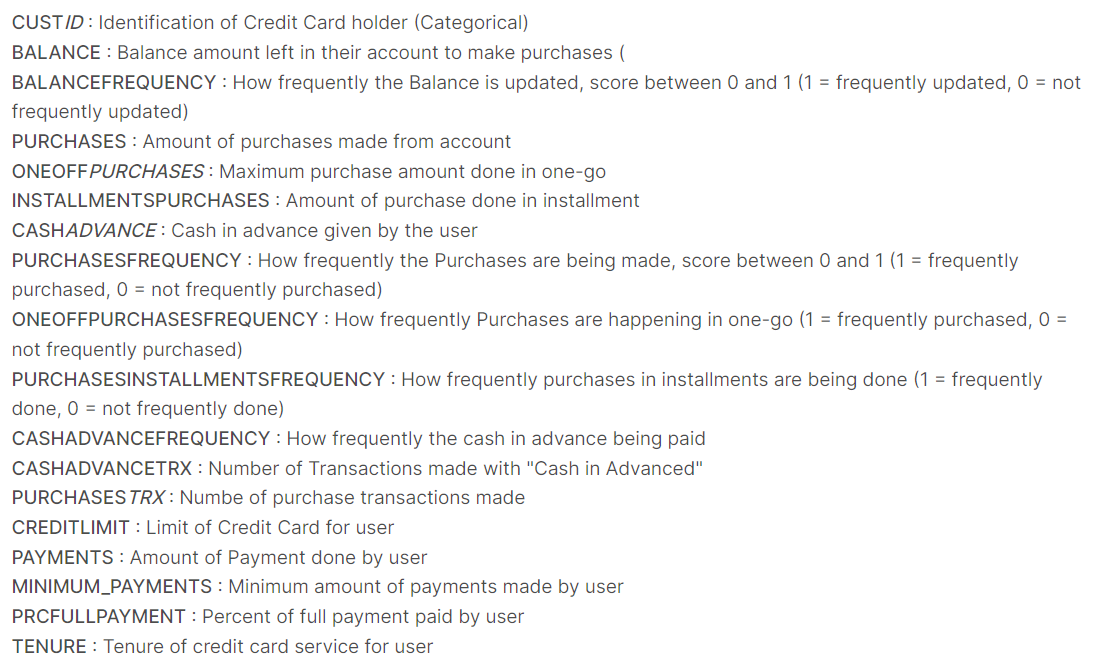

In [3]:
data= pd.read_csv("/content/CC GENERAL.csv")
print(data.shape)
data.head()

(8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


#Dealing with Missing Values

In [5]:
data.isnull().sum().sort_values(ascending=False).head()

MINIMUM_PAYMENTS    313
CREDIT_LIMIT          1
CUST_ID               0
BALANCE               0
PRC_FULL_PAYMENT      0
dtype: int64

Imputing these missing values with mean

In [6]:
data.loc[(data['MINIMUM_PAYMENTS'].isnull()==True),'MINIMUM_PAYMENTS']=data['MINIMUM_PAYMENTS'].mean()
data.loc[(data['CREDIT_LIMIT'].isnull()==True),'CREDIT_LIMIT']=data['CREDIT_LIMIT'].mean()

In [7]:
data.isnull().sum().sort_values(ascending=False).head()

CUST_ID             0
BALANCE             0
PRC_FULL_PAYMENT    0
MINIMUM_PAYMENTS    0
PAYMENTS            0
dtype: int64

#Dealing with Outliers

Check for outliers - seems like data have many outliers!

In [4]:
data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


Dealing with Outliers
By dropping outliers we can lose many rows as there are too many outliers in dataset. So making ranges to deal with extreme values.

In [8]:
columns=['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
        'PAYMENTS', 'MINIMUM_PAYMENTS']

for c in columns:
    
    Range=c+'_RANGE'
    data[Range]=0        
    data.loc[((data[c]>0)&(data[c]<=500)),Range]=1
    data.loc[((data[c]>500)&(data[c]<=1000)),Range]=2
    data.loc[((data[c]>1000)&(data[c]<=3000)),Range]=3
    data.loc[((data[c]>3000)&(data[c]<=5000)),Range]=4
    data.loc[((data[c]>5000)&(data[c]<=10000)),Range]=5
    data.loc[((data[c]>10000)),Range]=6

In [9]:
columns=['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 
         'CASH_ADVANCE_FREQUENCY', 'PRC_FULL_PAYMENT']

for c in columns:
    
    Range=c+'_RANGE'
    data[Range]=0
    data.loc[((data[c]>0)&(data[c]<=0.1)),Range]=1
    data.loc[((data[c]>0.1)&(data[c]<=0.2)),Range]=2
    data.loc[((data[c]>0.2)&(data[c]<=0.3)),Range]=3
    data.loc[((data[c]>0.3)&(data[c]<=0.4)),Range]=4
    data.loc[((data[c]>0.4)&(data[c]<=0.5)),Range]=5
    data.loc[((data[c]>0.5)&(data[c]<=0.6)),Range]=6
    data.loc[((data[c]>0.6)&(data[c]<=0.7)),Range]=7
    data.loc[((data[c]>0.7)&(data[c]<=0.8)),Range]=8
    data.loc[((data[c]>0.8)&(data[c]<=0.9)),Range]=9
    data.loc[((data[c]>0.9)&(data[c]<=1.0)),Range]=10

In [10]:
columns=['PURCHASES_TRX', 'CASH_ADVANCE_TRX']  

for c in columns:
    
    Range=c+'_RANGE'
    data[Range]=0
    data.loc[((data[c]>0)&(data[c]<=5)),Range]=1
    data.loc[((data[c]>5)&(data[c]<=10)),Range]=2
    data.loc[((data[c]>10)&(data[c]<=15)),Range]=3
    data.loc[((data[c]>15)&(data[c]<=20)),Range]=4
    data.loc[((data[c]>20)&(data[c]<=30)),Range]=5
    data.loc[((data[c]>30)&(data[c]<=50)),Range]=6
    data.loc[((data[c]>50)&(data[c]<=100)),Range]=7
    data.loc[((data[c]>100)),Range]=8

In [11]:
data.drop(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY',  'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT' ], axis=1, inplace=True)

X= np.asarray(data)

In [13]:
data

,TENURE,BALANCE_RANGE,PURCHASES_RANGE,ONEOFF_PURCHASES_RANGE,INSTALLMENTS_PURCHASES_RANGE,CASH_ADVANCE_RANGE,CREDIT_LIMIT_RANGE,PAYMENTS_RANGE,MINIMUM_PAYMENTS_RANGE,BALANCE_FREQUENCY_RANGE,PURCHASES_FREQUENCY_RANGE,ONEOFF_PURCHASES_FREQUENCY_RANGE,PURCHASES_INSTALLMENTS_FREQUENCY_RANGE,CASH_ADVANCE_FREQUENCY_RANGE,PRC_FULL_PAYMENT_RANGE,PURCHASES_TRX_RANGE,CASH_ADVANCE_TRX_RANGE
0,12,1,1,0,1,0,2,1,1,9,2,0,1,0,0,1,0
1,12,4,0,0,0,5,5,4,3,10,0,0,0,3,3,0,1
2,12,3,2,2,0,0,5,2,2,10,10,10,0,0,0,3,0
3,12,3,3,3,0,1,5,0,2,7,1,1,0,1,0,1,1
4,12,2,1,1,0,0,3,2,1,10,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,6,1,1,0,1,0,2,1,1,10,10,0,9,0,5,2,0
8946,6,1,1,0,1,0,2,1,2,10,10,0,9,0,0,2,0
8947,6,1,1,0,1,0,2,1,1,9,9,0,7,0,3,1,0
8948,6,1,0,0,0,1,1,1,1,9,0,0,0,2,3,0,1


#Normalizing input values.

In [14]:
scale = StandardScaler()
X = scale.fit_transform(X)
X.shape

(8950, 17)

#Clustering using Kmeans

In [15]:
n_clusters=30
cost=[]
for i in range(1,n_clusters):
    kmean= KMeans(i)
    kmean.fit(X)
    cost.append(kmean.inertia_)  

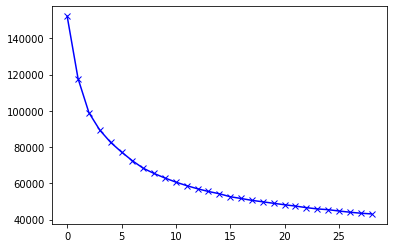

In [16]:
plt.plot(cost, 'bx-')

#Choosing 6 no of clusters

In [17]:
kmean= KMeans(6)
kmean.fit(X)
labels=kmean.labels_

In [21]:
(data.shape,labels.shape)

((8950, 17), (8950,))

In [18]:
clusters=pd.concat([data, pd.DataFrame({'cluster':labels})], axis=1)
clusters.head()

,TENURE,BALANCE_RANGE,PURCHASES_RANGE,ONEOFF_PURCHASES_RANGE,INSTALLMENTS_PURCHASES_RANGE,CASH_ADVANCE_RANGE,CREDIT_LIMIT_RANGE,PAYMENTS_RANGE,MINIMUM_PAYMENTS_RANGE,BALANCE_FREQUENCY_RANGE,PURCHASES_FREQUENCY_RANGE,ONEOFF_PURCHASES_FREQUENCY_RANGE,PURCHASES_INSTALLMENTS_FREQUENCY_RANGE,CASH_ADVANCE_FREQUENCY_RANGE,PRC_FULL_PAYMENT_RANGE,PURCHASES_TRX_RANGE,CASH_ADVANCE_TRX_RANGE,cluster
0,12,1,1,0,1,0,2,1,1,9,2,0,1,0,0,1,0,1
1,12,4,0,0,0,5,5,4,3,10,0,0,0,3,3,0,1,2
2,12,3,2,2,0,0,5,2,2,10,10,10,0,0,0,3,0,3
3,12,3,3,3,0,1,5,0,2,7,1,1,0,1,0,1,1,1
4,12,2,1,1,0,0,3,2,1,10,1,1,0,0,0,1,0,1


#Profiling Clusters

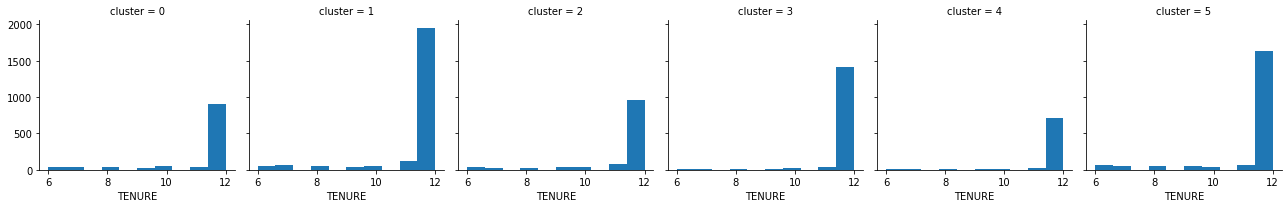

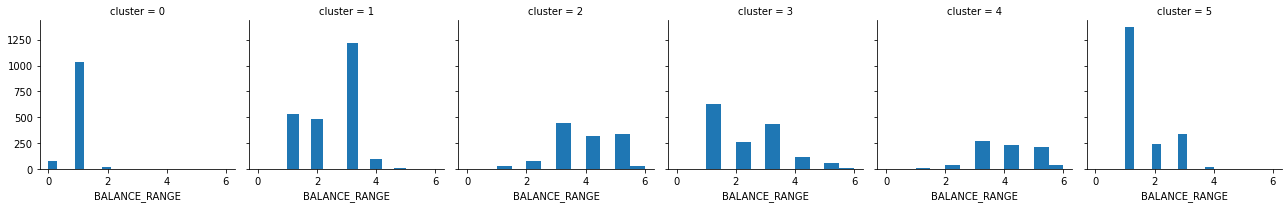

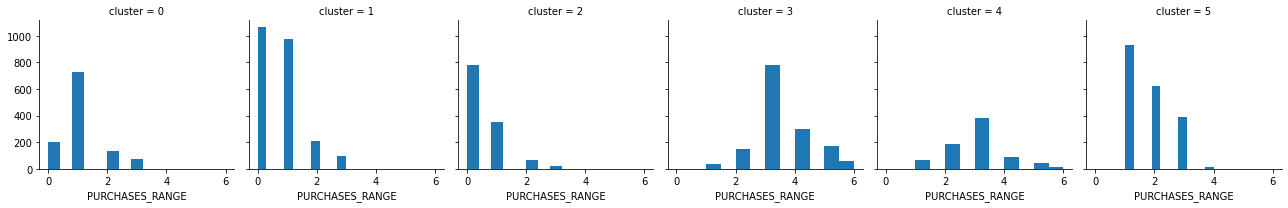

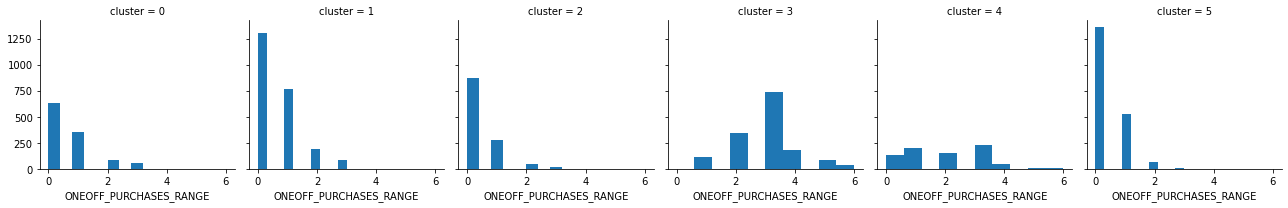

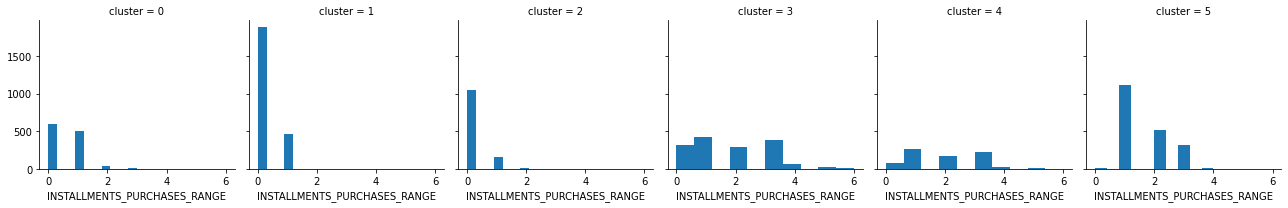

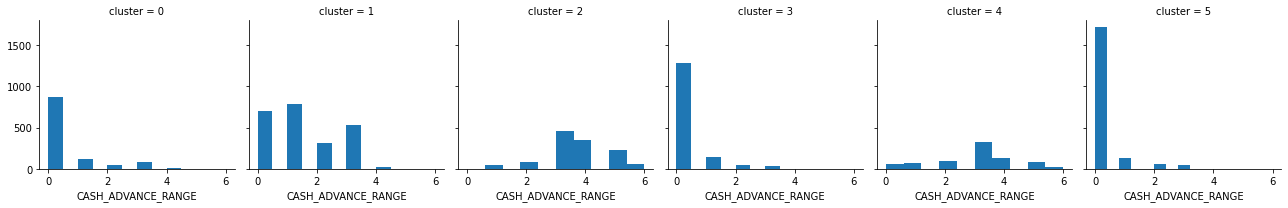

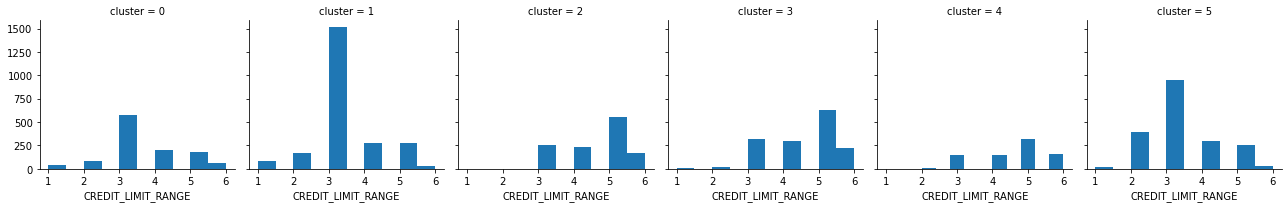

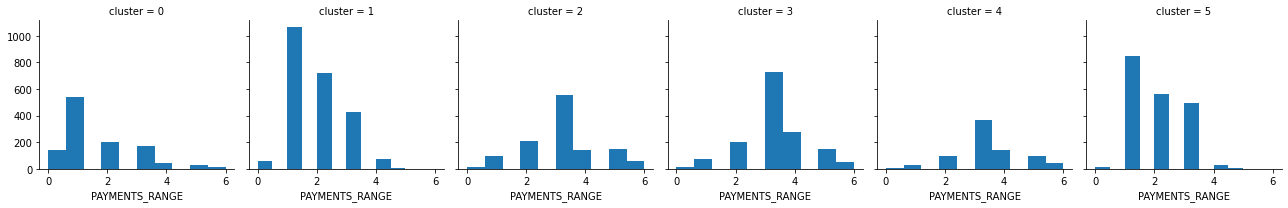

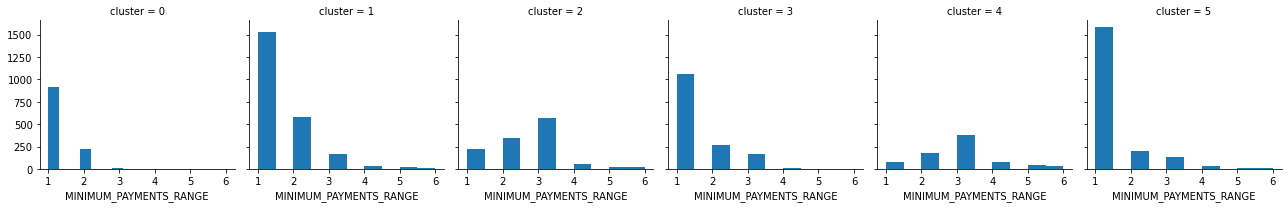

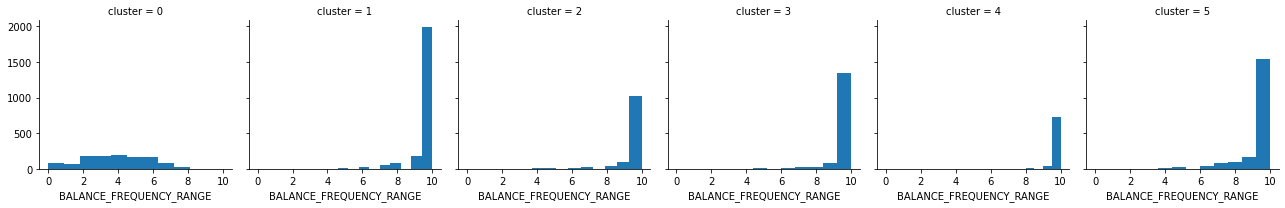

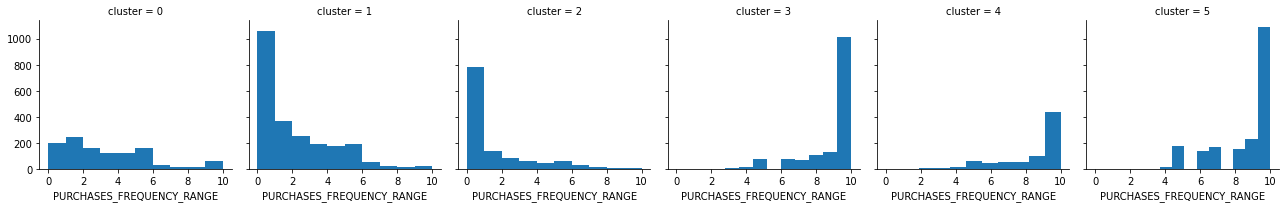

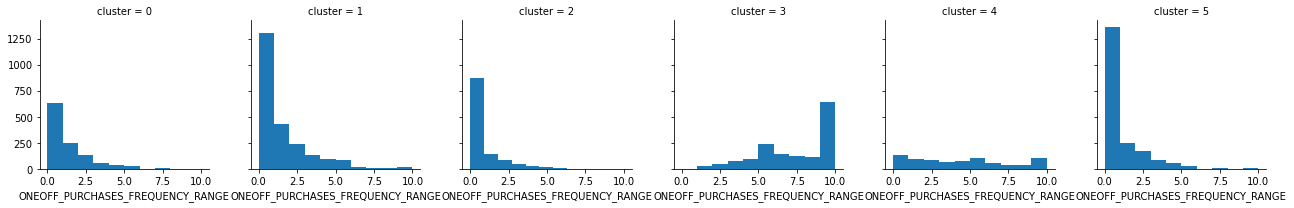

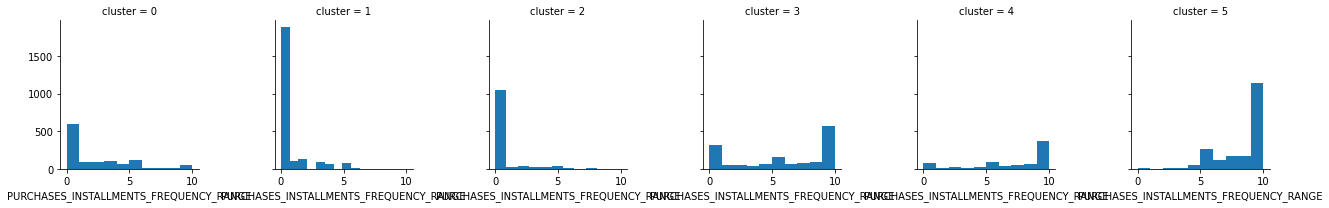

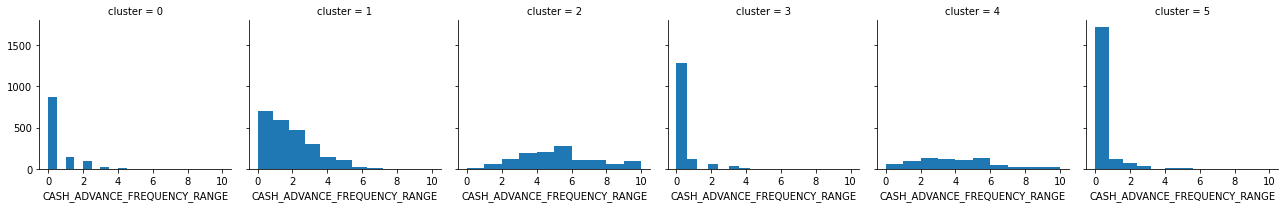

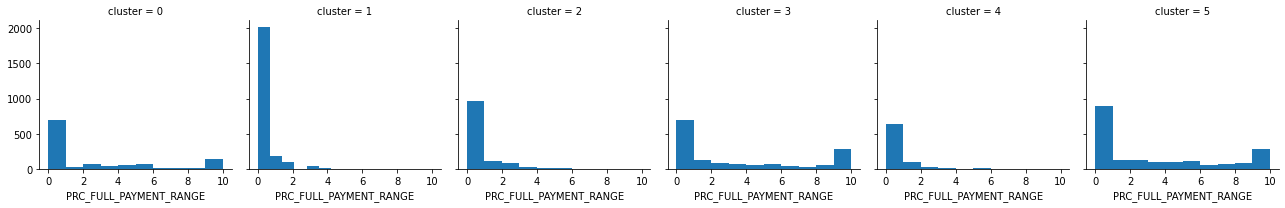

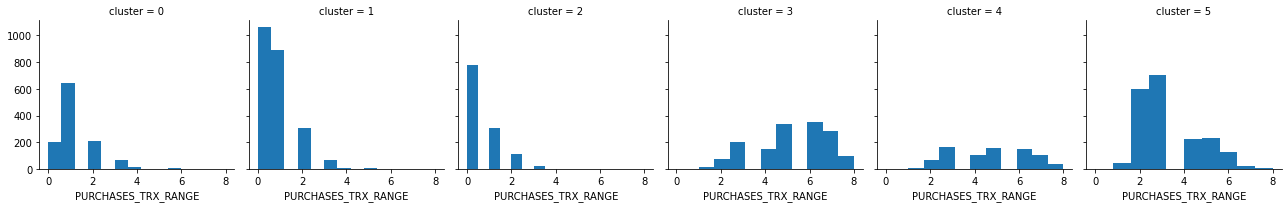

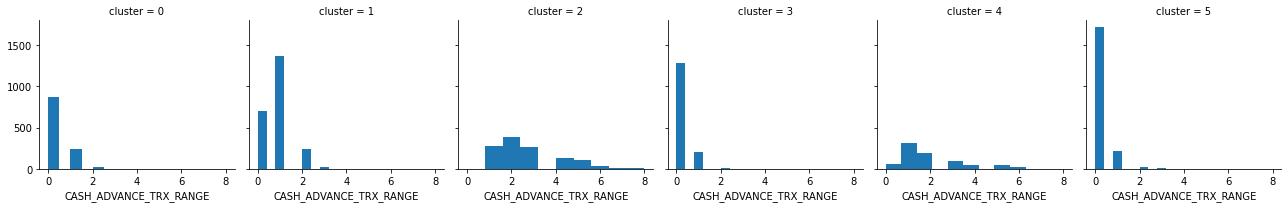

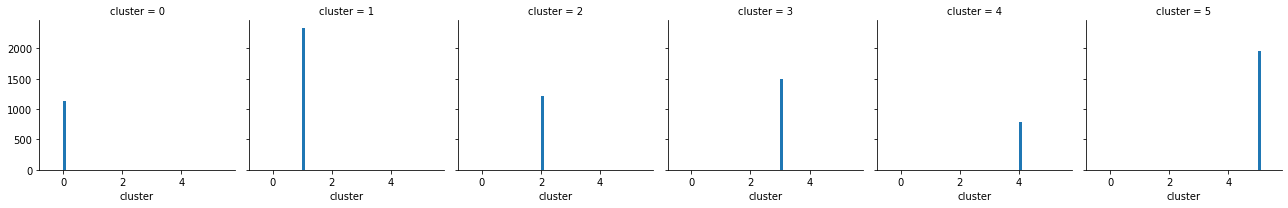

In [22]:
for c in clusters:
    grid= sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)

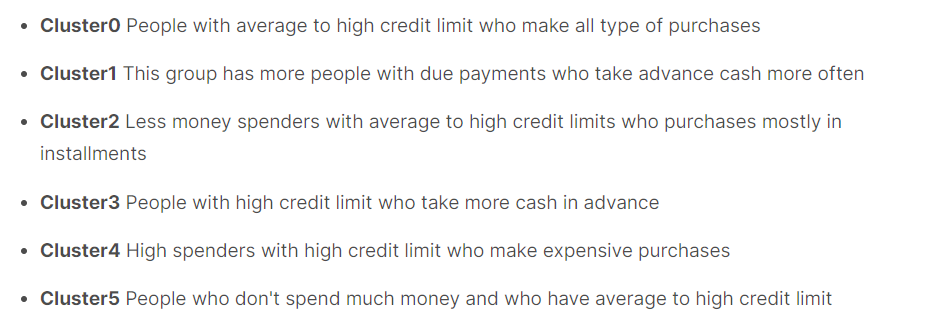

#Visualization of Clusters - Using PCA to transform data to 2 dimensions for visualization

In [23]:
dist = 1 - cosine_similarity(X)

pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)
X_PCA.shape

(8950, 2)

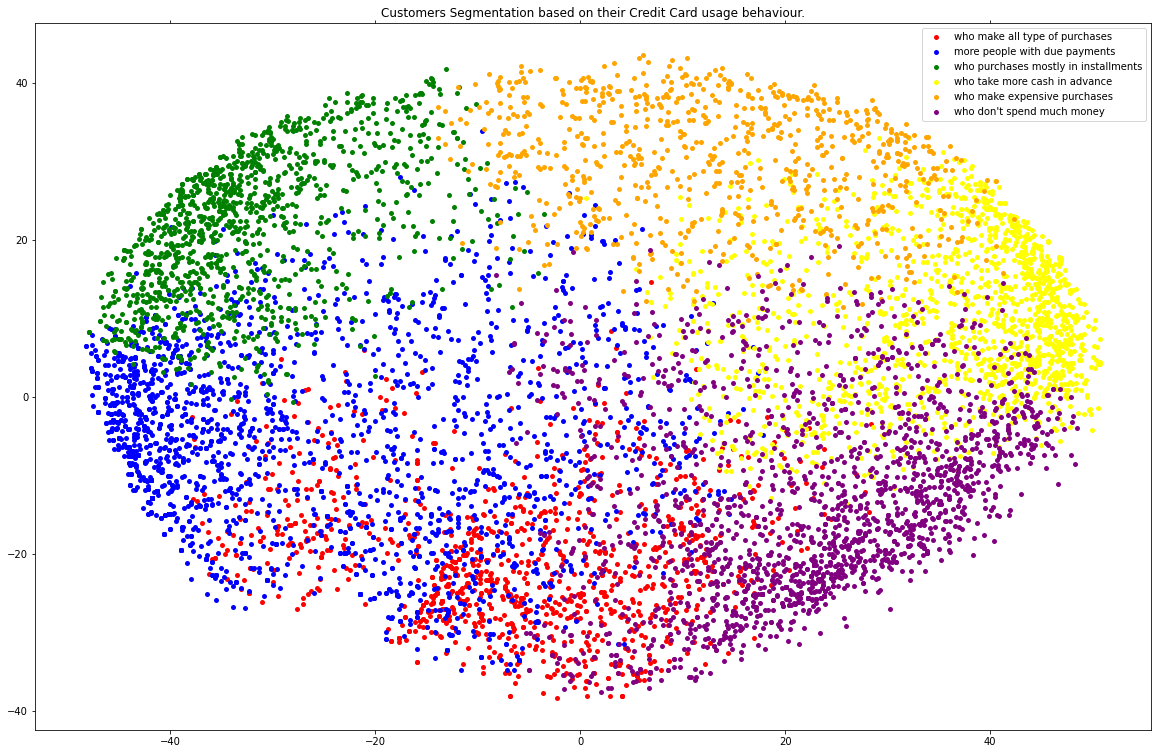

In [25]:
x, y = X_PCA[:, 0], X_PCA[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow', 
          4: 'orange',  
          5:'purple'}

names = {0: 'who make all type of purchases', 
         1: 'more people with due payments', 
         2: 'who purchases mostly in installments', 
         3: 'who take more cash in advance', 
         4: 'who make expensive purchases',
         5:'who don\'t spend much money'}
  
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name],label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
ax.legend()
ax.set_title("Customers Segmentation based on their Credit Card usage behaviour.")
plt.show()